In [6]:
# SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: MIT
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [7]:
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import cv2
import math
from copy import deepcopy
from typing import List, Optional
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import torch_geometric
from torch_geometric.utils import to_networkx

# from nfn.common.data import state_dict_to_tensors
#from experiments.data_utils import SirenAndOriginalDataset
#from experiments.graph_data import NNGraphDatasetNFN
#from data_utils import SirenAndOriginalDataset
#from graph_data import NNGraphDatasetNFN

### Convnet conversion

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Flatten(nn.Module):
    def forward(self, x): return x.reshape(x.shape[0], -1)
    
def make_resnet(conv_layers=2, hidden_dim=32, in_dim=3, num_classes=10, activation='relu', norm='bn'):
    layers = []
    activation_builder = {'relu': nn.ReLU,
                          'gelu': nn.GELU}[activation]
    norm_builder = {'bn': nn.BatchNorm2d,
                    'gn': lambda dim: nn.GroupNorm(2, dim),
                    'none': None}[norm]

    layers.append(nn.Conv2d(in_dim, hidden_dim, 5))
    if norm_builder is not None: layers.append(norm_builder(hidden_dim))
    layers.append(activation_builder())

    for _ in range(conv_layers):
        layers.append(BasicBlock(hidden_dim, hidden_dim))

    layers.append(nn.AdaptiveAvgPool2d((1,1)))
    layers.append(Flatten())

    layers.append(nn.Linear(hidden_dim, num_classes))
    return nn.Sequential(*layers)
model = make_resnet(conv_layers=1, hidden_dim=32, in_dim=3, num_classes=10)
sum(p.numel() for p in model.parameters())

21386

In [9]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=.1, activation='relu'):
        super().__init__()
        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        return x + self.lin2(self.dropout(self.activation(self.lin1(x))))
    
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0, bias=True, batch_first=True):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, bias=bias, batch_first=batch_first)
    def forward(self, x):
        return x + self.attn(x, x, x, need_weights=False)[0]
model = SelfAttention(4, 2, batch_first=True, bias=False)

class SinPosEnc(nn.Module):
    # based on https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.freqs = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
    def forward(self, x):
        # x: B x N x D
        seq_len = x.shape[1]
        idx = torch.arange(seq_len, device=x.device).unsqueeze(1).float() # N x 1
        freqs = self.freqs.to(idx) # 1 x D/2
        pe = torch.zeros(1, seq_len, self.dim, device=x.device)
        pe[0, :, 0::2] = torch.sin(idx * freqs) 
        pe[0, :, 1::2] = torch.cos(idx * freqs) 
        return x + pe
    
class Imageto1DSeq(nn.Module):
    # B x C x H x W -> B x H*W x C
    def forward(self, x): return x.reshape(x.shape[0], x.shape[1], -1).transpose(2, 1)


def make_transformer(in_dim, hidden_dim, num_heads, out_dim, dropout=0.0, num_layers=2, vit=True, patch_size=4):
    layers = []

    if vit:
        # input B x C x H x W
        layers.append(nn.Conv2d(in_dim, hidden_dim, patch_size, stride=patch_size))
        layers.append(Imageto1DSeq())
        layers.append(SinPosEnc(hidden_dim))
    else:
        # input B x N x C
        layers.append(nn.Linear(in_dim, hidden_dim))

    for l in range(num_layers):
        layers.append(nn.LayerNorm(hidden_dim))
        layers.append(SelfAttention(hidden_dim, num_heads, dropout=dropout))
        layers.append(nn.LayerNorm(hidden_dim))
        layers.append(PositionwiseFeedForward(hidden_dim, 4*hidden_dim, dropout=dropout))
    # B x N x hidden_dim -> B x hidden_dim
    class AvgPoolSeq(nn.Module):
        def forward(self, x): return x.mean(1)
    layers.append(AvgPoolSeq())
    layers.append(nn.Linear(hidden_dim, out_dim))
    return nn.Sequential(*layers)


model = make_transformer(3, 4, 2, 2)
#model(torch.randn(8, 8, 3))
model = make_transformer(3, 4, 2, 2, vit=True)
model(torch.randn(8, 3, 5, 5))

tensor([[-0.7677, -0.2006],
        [ 0.9519,  0.7263],
        [ 0.4211,  0.4242],
        [ 0.9319,  0.9019],
        [ 0.5973,  0.2498],
        [ 0.5554, -0.0424],
        [ 1.0206,  0.8301],
        [ 0.5232,  0.3623]], grad_fn=<AddmmBackward0>)

In [10]:
class EquivSetLinear(nn.Module):
    ''' Equivariant DeepSets linear layer 
        Input is B x D x N
        B is batch dim
        D is feature dim
        N is set size
    '''
    def __init__(self, in_dim, out_dim):
        super().__init__()
        # 1 x 1 convs for elementwise linear
        self.lin1 = nn.Conv1d(in_dim, out_dim, 1)
        self.lin2 = nn.Conv1d(in_dim, out_dim, 1, bias=False) # second bias redundant

    def forward(self, x):
        # x: B x C x H x W
        x1 = self.lin1(x)
        x2 = self.lin2(x.mean(2, keepdim=True))
        return x1 + x2
    
model = nn.Sequential(EquivSetLinear(2, 3), nn.ReLU(), EquivSetLinear(3, 1))
print(model(torch.randn(10, 2, 5)).shape)

torch.Size([10, 1, 5])


In [11]:
class TriplanarGrid(nn.Module):
    def __init__(self, resolution: int, fdim: int):
        super().__init__()
        self._fdim = fdim
        tgrid = torch.empty(1, 3 * fdim, resolution, resolution)
        nn.init.xavier_uniform_(tgrid)
        self.tgrid = nn.Parameter(tgrid, requires_grad=True)

    def forward(self, x: torch.Tensor):
        """Trilinear interpolation of voxel grid features

        Args:
          x: torch.Tensor. Expects input `x` to have shape `[N,3]`. Should be in
             the range [-1,1]^3 (convention imposed by `F.grid_sample`).

        Returns:
          z: torch.Tensor. Has shape [N, K]
        """
        # To match the expected input shape of F.grid_sample
        xy = x[:,(0,1)].view(1, -1, 1, 2)
        yz = x[:,(1,2)].view(1, -1, 1, 2)
        zx = x[:,(2,0)].view(1, -1, 1, 2)

        tgridxy, tgridyz, tgridzx = torch.split(self.tgrid, self._fdim, 1)

        outxy = F.grid_sample(tgridxy, xy).view(x.shape[0], -1)
        outyz = F.grid_sample(tgridyz, yz).view(x.shape[0], -1)
        outzx = F.grid_sample(tgridzx, zx).view(x.shape[0], -1)
        return torch.cat([x, outxy + outyz + outzx], -1)
    
class WeightEncodedImplicit(nn.Module):
    """Weight encoded implicit networks
    
    As described in https://arxiv.org/pdf/2009.09808.pdf
    """
    def __init__(
        self, mlp_layers: List[int], activation=nn.ReLU(),
        out_activation=nn.Tanh(), triplanar_res: Optional[int] = None,
        triplanar_fdim: Optional[int] = None, spherical_bias: bool = False
        ):
        super().__init__()
        self.n_layers = len(mlp_layers)

        layers = []
        indim = 3
        if triplanar_res is not None:
            layers.append(TriplanarGrid(triplanar_res, triplanar_fdim))
            indim = triplanar_fdim + 3
        layers.append(nn.Linear(indim, mlp_layers[0]))
        for i in range(self.n_layers - 1):
            layers.append(deepcopy(activation))
            layers.append(nn.Linear(mlp_layers[i], mlp_layers[i + 1]))
        # layers[-1].bias.data.zero_()
        self.layers = nn.Sequential(
            *layers
        )
        self.out_actvn = out_activation
        self.spherical_bias = spherical_bias
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Network forward pass

        Args:
            x (torch.Tensor): Input coordinate (B, 3)

        Returns:
            torch.Tensor: Output sdf prediction (B, 1)
        """
        o = self.layers(x)
        if self.out_actvn:
            o = self.out_actvn(o)
        if self.spherical_bias:
            o += (x * x).sum(1, keepdim=True).sqrt_() - 0.5
        return o


model = TriplanarGrid(4, 2)
model(torch.randn(7, 3)*.1)

/home/siddhartha/gmn/venv/lib/python3.10/site-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor([[-0.1293,  0.0194,  0.0476, -0.0394, -0.1127],
        [ 0.0655,  0.0552,  0.0097, -0.1296, -0.1324],
        [-0.1273,  0.0285, -0.1860, -0.1564, -0.1091],
        [ 0.0347, -0.0632, -0.1813, -0.0898,  0.0202],
        [-0.1289,  0.1257, -0.2609,  0.0223, -0.0204],
        [ 0.0174,  0.0444, -0.0940, -0.0331,  0.0286],
        [ 0.1111,  0.1412, -0.1253,  0.0241,  0.0981]], grad_fn=<CatBackward0>)

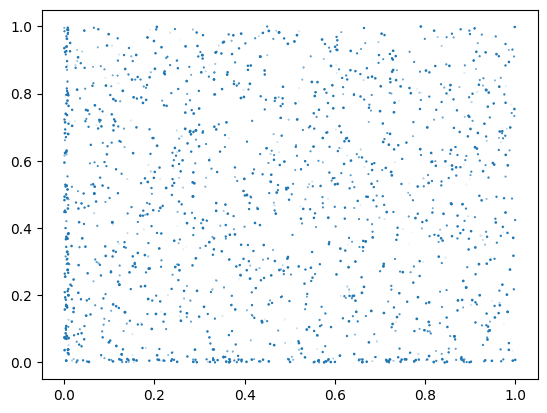

In [12]:
xyz = torch.rand(10000, 3)
sdfs = model(xyz)
surface_pts = xyz[torch.where(sdfs.abs() < 1e-2)[0], :]
plt.scatter(surface_pts[:, 0], surface_pts[:, 1], surface_pts[:, 2])

In [13]:
in_channels = 2
out_channels = 4
kernel_size = 3
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.flatten(x, 1)
    
conv = nn.Conv2d(in_channels, out_channels, kernel_size)
cnn = nn.Sequential(nn.Conv2d(3, 4, 3),
                      nn.BatchNorm2d(4),
                      nn.ReLU(),
                      nn.Conv2d(4, 5, 3),
                      nn.ReLU(),
                      nn.AdaptiveAvgPool2d((1,1)),
                      Flatten(),
                      nn.LayerNorm(5),
                      nn.Linear(5, 1)
                     )
cnn2 = nn.Sequential(nn.Conv1d(2,5,3),
                       nn.ReLU(),
                       nn.AdaptiveAvgPool1d(1),
                       Flatten(),
                       nn.Linear(5, 1))
cnn3 = nn.Sequential(nn.Conv1d(1,2,2),
                       nn.ReLU(),
                       nn.AdaptiveAvgPool1d(1),
                       Flatten(),
                       nn.Linear(2, 1))
print([p.numel() for p in cnn3.parameters()])
cnn(torch.randn(5, 3, 10, 10))
cnn2(torch.randn(5, 2, 10))

cnn3(torch.randn(5, 1, 2))

[4, 2, 2, 1]


tensor([[-0.1491],
        [-0.1523],
        [-0.1426],
        [-0.1952],
        [-0.2692]], grad_fn=<AddmmBackward0>)

In [14]:
CONV_LAYERS = [nn.Conv1d, nn.Conv2d, nn.Conv3d]
NORM_LAYERS = [nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d,
               nn.LayerNorm,
               nn.GroupNorm,
               nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d]

NODE_TYPES = {'neuron': 0,
              'bias': 1,
              'channel': 2,
              'channel_bias': 3,
              'bn_gamma': 4,
              'bn_beta': 5,
              'ln_gamma': 6,
              'ln_beta': 7,
              'gn_gamma': 8,
              'gn_beta': 9,
              'in_gamma': 10,
              'in_beta': 11,
              'attention_neuron': 12,
              'attention_bias': 13,
              'deepsets_neuron': 14,
              'deepsets_bias': 15,
              'triplanar': 16}

EDGE_TYPES = {'lin_weight': 0,
              'lin_bias': 1,
              'conv_weight': 2,
              'conv_bias': 3,
              'residual': 4,
              'bn_gamma': 5,
              'bn_beta': 6,
              'ln_gamma': 7,
              'ln_beta': 8,
              'gn_gamma': 9,
              'gn_beta': 10,
              'in_gamma': 11,
              'in_beta': 12,
              'triplanar': 13}
RESIDUAL_LAYERS = {PositionwiseFeedForward}

def sequential_to_arch(model):
    # input can be a nn.Sequential
    # or ordered list of modules
    arch = []
    weight_bias_modules = CONV_LAYERS + [nn.Linear] + NORM_LAYERS
    for module in model:
        layer = [type(module)]
        if type(module) in weight_bias_modules:
            layer.append(module.weight)
            layer.append(module.bias)
        elif type(module) == BasicBlock:
            layer.extend([
                module.conv1.weight,
                module.bn1.weight,
                module.bn1.bias,
                module.conv2.weight,
                module.bn2.weight,
                module.bn2.bias])
            if len(module.shortcut) > 0:
                layer.extend([
                    module.shortcut[0].weight,
                    module.shortcut[1].weight,
                    module.shortcut[1].bias])
        elif type(module) == PositionwiseFeedForward:
            layer.append(module.lin1.weight)
            layer.append(module.lin1.bias)
            layer.append(module.lin2.weight)
            layer.append(module.lin2.bias)
        elif type(module) == SelfAttention:
            layer.append(module.attn.in_proj_weight)
            layer.append(module.attn.in_proj_bias)
            layer.append(module.attn.out_proj.weight)
            layer.append(module.attn.out_proj.bias)
        elif type(module) == EquivSetLinear:
            layer.append(module.lin1.weight)
            layer.append(module.lin1.bias)
            layer.append(module.lin2.weight)
        elif type(module) == TriplanarGrid:
            layer.append(module.tgrid)
        else:
            if len(list(module.parameters())) != 0:
                raise ValueError(f'{type(module)} has parameters but is not yet supported')
            continue
        arch.append(layer)
    return arch
arch = sequential_to_arch(cnn2)

In [15]:
def make_node_feat(neuron_num, l, node_type, end_neuron=False):
    ''' end_neuron means whether it is an input or output neuron
    x has 3 dimensions:
    x[:, 0] is layer number
    x[:, 1] is neuron order (if the neuron is an input or output neuron of the whole network)
    x[:, 2] is the node type
    '''
    x = torch.zeros(neuron_num, 3, dtype=torch.long)
    x[:, 0] = l
    if not end_neuron:
        # if it is a hidden neuron, don't give an order
        x[:, 1] = -1
    else:
        x[:, 1] = torch.arange(neuron_num)
    x[:, 2] = node_type
    return x

def make_edge_attr(weights, l, edge_type, conv_size=None, triplanar_size=None):
    '''
    weights is num_edges x 1
    triplanar size is of form (dim, N), where N is resolution [only for triplanar grid module]
    edge_attr has 6 dimensions
    edge_attr[:, 0] holds parameters
    edge_attr[:, 1] is layer number
    edge_attr[:, 2] is edge type
    edge_attr[:, (3,4,5)] are position in convolution kernel (if conv_size is not None)
    edge_attr[:, (3,4)] are position in TODO
    '''
    edge_attr = torch.zeros(weights.shape[0], 6)
    edge_attr[:, 0] = weights[:, 0]
    edge_attr[:, 1] = l
    edge_attr[:, 2] = edge_type
    edge_attr[:, 3:] = -1
    
    # encode position of convolution weights
    if conv_size is not None:
        positions = torch.zeros(conv_size)
        kernel_size = conv_size[2:]
        ndim = len(kernel_size)
        #kernel_pos = torch.arange(math.prod(kernel_size)).reshape(kernel_size)
        if ndim == 1:
            x = torch.arange(kernel_size[0])[None, None, :]
            positions[:] = x
            edge_attr[:, 3] = positions.flatten()
        if ndim == 2:
            x = torch.arange(kernel_size[0])[None, None, :, None]
            y = torch.arange(kernel_size[1])[None, None, None, :]
            positions[:] = x
            edge_attr[:, 3] = positions.flatten()
            positions[:] = y
            edge_attr[:, 4] = positions.flatten()
        if ndim == 3:
            x = torch.arange(kernel_size[0])[None, None, :, None, None]
            y = torch.arange(kernel_size[1])[None, None, None, :, None]
            z = torch.arange(kernel_size[2])[None, None, None, None, :]
            positions[:] = x
            edge_attr[:, 3] = positions.flatten()
            positions[:] = y
            edge_attr[:, 4] = positions.flatten()
            positions[:] = z
            edge_attr[:, 5] = positions.flatten()
    elif triplanar_size is not None:
        d, N = triplanar_size
        xyz_vals = torch.zeros(1,3*d,N,N, 3)
        # encode xy
        x = torch.linspace(-1, 1, steps=N)[None, None, :, None]
        y = torch.linspace(-1, 1, steps=N)[None, None, None, :]
        xyz_vals[:, :d, :, :, 0] = x
        xyz_vals[:, :d, :, :, 1] = y
        xyz_vals[:, :d, :, :, 2] = 0
        # encode yz
        y = torch.linspace(-1, 1, steps=N)[None, None, :, None]
        z = torch.linspace(-1, 1, steps=N)[None, None, None, :]
        xyz_vals[:, d:2*d, :, :, 0] = 0
        xyz_vals[:, d:2*d, :, :, 1] = y
        xyz_vals[:, d:2*d, :, :, 2] = z
        # encode zx
        z = torch.linspace(-1, 1, steps=N)[None, None, :, None]
        x = torch.linspace(-1, 1, steps=N)[None, None, None, :]
        xyz_vals[:, 2*d:, :, :, 0] = x
        xyz_vals[:, 2*d:, :, :, 1] = 0
        xyz_vals[:, 2*d:, :, :, 2] = z
        xvals = xyz_vals[..., 0]
        yvals = xyz_vals[..., 1]
        zvals = xyz_vals[..., 2]
        edge_attr[:, 3] = xvals.flatten()
        edge_attr[:, 4] = yvals.flatten()
        edge_attr[:, 5] = zvals.flatten()
        
    return edge_attr

def make_residual_feat(num_neurons, l):
    edge_attr = torch.zeros(num_neurons, 6)
    edge_attr[:, 0] = 1 # all weights set to 1
    edge_attr[:, 1] = l
    edge_attr[:, 2] = EDGE_TYPES['residual']
    edge_attr[:, 3:] = -1
    return edge_attr

def conv_to_graph(weight, bias, l, in_neuron_idx, out_neuron=False, curr_idx=0, self_loops=True):
    # should work for Conv1d, Conv2d, Conv3d
    edge_attr = []
    edge_index = []
    
    input_neurons = weight.shape[1]
    assert input_neurons == in_neuron_idx.shape[0]
    
    feat = make_node_feat(input_neurons, l, NODE_TYPES['channel'], end_neuron=(l==0))
    input_x = feat
    
    output_neurons = weight.shape[0]
    #out_neuron_idx = torch.arange(output_neurons) + feat.shape[0]
    out_neuron_idx = torch.arange(output_neurons) + in_neuron_idx.max() + 1
    if out_neuron_idx.min() < curr_idx:
        out_neuron_idx = out_neuron_idx + curr_idx - out_neuron_idx.min()
    feat = make_node_feat(output_neurons, l+1, NODE_TYPES['channel'], out_neuron)
    other_x = feat
    

    filter_size = math.prod(weight.shape[2:])
    edge_attr.append(make_edge_attr(
                    weight.reshape(-1, 1), l, EDGE_TYPES['conv_weight'],
                    conv_size=weight.shape))
    weight_edges = torch.cartesian_prod(in_neuron_idx,
                        out_neuron_idx).T.repeat_interleave(filter_size, dim=1)
    edge_index.append(weight_edges)

    if bias is not None: # checks if layer has bias
        if self_loops:
            edge_attr.append(make_edge_attr(
                        bias.reshape(-1, 1), l, EDGE_TYPES['conv_bias']))
            weight_edges = torch.cat((out_neuron_idx[None, :],
                                      out_neuron_idx[None, :]), dim=0) # self loops
            edge_index.append(weight_edges)
        else:
            edge_attr.append(make_edge_attr(
                        bias.reshape(-1, 1), l, EDGE_TYPES['conv_bias']))
            bias_node = make_node_feat(1, l+1, NODE_TYPES['channel_bias'], False)
            bias_num = out_neuron_idx.max() + 1
            weight_edges = torch.cat([
                            torch.tensor([bias_num]).repeat(output_neurons)[None, :],
                            out_neuron_idx[None, :]
                            ], 0)
            other_x = torch.cat([other_x, bias_node], 0)
            edge_index.append(weight_edges)
        
    # does not work for when residual layer is first layer
    added_x = other_x if l > 0 else torch.cat([input_x, other_x], 0)
    
    edge_attr = torch.cat(edge_attr, dim=0)
    edge_index = torch.cat(edge_index, dim=1)
    
    ret = { 'input_neurons': input_neurons,
            'output_neurons': output_neurons,
            'in_neuron_idx': in_neuron_idx,
            'out_neuron_idx': out_neuron_idx,
            'added_x': added_x,
            'edge_index': edge_index,
            'edge_attr': edge_attr}
    return ret

def linear_to_graph(weight, bias, l, in_neuron_idx, out_neuron=False, curr_idx=0, self_loops=True, out_neuron_idx=None, label=''):
    ''' if out_neuron_idx is not None, then do not make new out neurons
    '''
    edge_attr = []
    edge_index = []
    
    input_neurons = weight.shape[1]
    assert input_neurons == in_neuron_idx.shape[0]
    
    feat = make_node_feat(input_neurons, l, NODE_TYPES[label + 'neuron'], end_neuron=(l==0))
    input_x = feat
    if l == 0:
        curr_idx += input_x.shape[0]
    
    output_neurons = weight.shape[0]
    if out_neuron_idx is None:
        # need to add out neurons
        out_neuron_idx = torch.arange(output_neurons) + in_neuron_idx.max() + 1
        if out_neuron_idx.min() < curr_idx:
            # if adding out_neurons, need to make sure they start at curr_idx
            out_neuron_idx = out_neuron_idx - out_neuron_idx.min() + curr_idx

        feat = make_node_feat(output_neurons, l+1, NODE_TYPES[label + 'neuron'], out_neuron)
        other_x = feat
        curr_idx += other_x.shape[0]
    else:
        # do not add new neurons
        other_x = None
    

    filter_size = math.prod(weight.shape[-2:])
    edge_attr.append(make_edge_attr(
                    weight.reshape(-1, 1), l, EDGE_TYPES['lin_weight']))
    weight_edges = torch.cartesian_prod(in_neuron_idx,
                        out_neuron_idx).T
    edge_index.append(weight_edges)

    if bias is not None: # checks if layer has bias
        if self_loops:
            edge_attr.append(make_edge_attr(
                        bias.reshape(-1, 1), l, EDGE_TYPES['lin_bias']))
            weight_edges = torch.cat((out_neuron_idx[None, :],
                                      out_neuron_idx[None, :]), dim=0) # self loops
            edge_index.append(weight_edges)
        else:
            edge_attr.append(make_edge_attr(
                        bias.reshape(-1, 1), l, EDGE_TYPES['lin_bias']))
            bias_node = make_node_feat(1, l+1, NODE_TYPES['bias'], False)
            bias_num = curr_idx
            curr_idx += 1
            weight_edges = torch.cat([
                            torch.tensor([bias_num]).repeat(output_neurons)[None, :],
                            out_neuron_idx[None, :]
                            ], 0)
            if other_x is not None:
                other_x = torch.cat([other_x, bias_node], 0)
            else:
                other_x = bias_node
            edge_index.append(weight_edges)
            
    if l > 0:
        added_x = other_x
    else:
        if other_x is not None:
            added_x = torch.cat([input_x, other_x], 0)
        else:
            added_x = input_x
        
    edge_attr = torch.cat(edge_attr, dim=0)
    edge_index = torch.cat(edge_index, dim=1)
    
    ret = { 'input_neurons': input_neurons,
            'output_neurons': output_neurons,
            'in_neuron_idx': in_neuron_idx,
            'out_neuron_idx': out_neuron_idx,
            'added_x': added_x,
            'edge_index': edge_index,
            'edge_attr': edge_attr}
    return ret

def norm_to_graph(gamma, beta, l, in_neuron_idx, out_neuron=False, curr_idx=0, self_loops=True, norm_type='bn'):
    # gamma, beta are both length d vectors
    edge_attr = []
    edge_index = []
    input_neurons = gamma.shape[0]
    assert input_neurons == in_neuron_idx.shape[0]
    
    feat = make_node_feat(input_neurons, l, NODE_TYPES['neuron'], end_neuron=(l==0))
    input_x = feat
    
    output_neurons = gamma.shape[0]
    out_neuron_idx = in_neuron_idx.clone()
    feat = make_node_feat(input_neurons, l, NODE_TYPES['neuron'], out_neuron)
    other_x = feat
    
    if self_loops:
        added_neurons = 0
        added_x = None
        weight_edges = torch.cat((out_neuron_idx[None, :],
                                  out_neuron_idx[None, :]), dim=0) # self loops
        edge_index.append(weight_edges)
        edge_index.append(weight_edges.clone())
    else:
        gamma_neuron = make_node_feat(1, l, NODE_TYPES[f'{norm_type}_gamma'], out_neuron)
        beta_neuron = make_node_feat(1, l, NODE_TYPES[f'{norm_type}_beta'], out_neuron)
        added_x = torch.cat([gamma_neuron, beta_neuron], 0)
        
        gamma_num = curr_idx
        beta_num = gamma_num + 1
        weight_edges = torch.cat([
            torch.tensor([gamma_num]).repeat(output_neurons)[None, :],
            in_neuron_idx[None, :] ], 0)
        edge_index.append(weight_edges)
        
        weight_edges = torch.cat([
            torch.tensor([beta_num]).repeat(output_neurons)[None, :],
            in_neuron_idx[None, :] ], 0)
        edge_index.append(weight_edges)
        
    edge_attr.append(make_edge_attr(
                    gamma.reshape(-1, 1), l, EDGE_TYPES[f'{norm_type}_gamma']))
    edge_attr.append(make_edge_attr(
                    beta.reshape(-1, 1), l, EDGE_TYPES[f'{norm_type}_beta']))
    
    edge_attr = torch.cat(edge_attr, dim=0)
    edge_index = torch.cat(edge_index, dim=1)
    
    ret = { 'input_neurons': input_neurons,
            'output_neurons': output_neurons,
            'in_neuron_idx': in_neuron_idx,
            'out_neuron_idx': out_neuron_idx,
            'added_x': added_x,
            'edge_index': edge_index,
            'edge_attr': edge_attr}
    return ret

def ffn_to_graph(weights1, biases1, weights2, biases2, l, in_neuron_idx, out_neuron=False, curr_idx=0, self_loops=True):
    # as in PositionwiseFeedForward from Transformer
    # 2-layer MLP with residual connection
    ret1 = linear_to_graph(weights1, biases1, l, in_neuron_idx, out_neuron=False, curr_idx=curr_idx, self_loops=self_loops)
    curr_idx += ret1['added_x'].shape[0]
    ret2 = linear_to_graph(weights2, biases2, l+1, ret1['out_neuron_idx'], out_neuron=out_neuron, curr_idx=curr_idx, self_loops=self_loops)
    
    added_x = torch.cat([ret1['added_x'], ret2['added_x']], 0)
    residuals = torch.cat([in_neuron_idx.unsqueeze(0), 
                           ret2['out_neuron_idx'].unsqueeze(0)], 0)
    residuals_feat = make_residual_feat(in_neuron_idx.shape[0], l)
    edge_index = torch.cat([ret1['edge_index'], ret2['edge_index'], residuals], 1)
    
    
    edge_attr = torch.cat([ret1['edge_attr'], ret2['edge_attr'], residuals_feat], 0)
    ret = {'input_neurons': ret1['input_neurons'],
           'output_neurons': ret2['output_neurons'],
           'in_neuron_idx': in_neuron_idx,
           'out_neuron_idx': ret2['out_neuron_idx'],
           'added_x': added_x,
           'edge_index': edge_index,
           'edge_attr': edge_attr}
    return ret

def basic_block_to_graph(params, l, in_neuron_idx, out_neuron=False, curr_idx=0, self_loops=True):
    # TODO
    # no biases in the convolutions
    ret1 = conv_to_graph(params[0], None, l, in_neuron_idx, out_neuron=False, curr_idx=curr_idx, self_loops=self_loops)
    if ret1['added_x'] is not None:
        curr_idx += ret1['added_x'].shape[0]
    middle_neuron_idx = ret1['out_neuron_idx']
    
    ret2 = norm_to_graph(params[1], params[2], l, middle_neuron_idx, out_neuron=False, curr_idx=curr_idx, self_loops=self_loops, norm_type='bn')
    if ret2['added_x'] is not None:
        curr_idx += ret2['added_x'].shape[0]
    
    ret3 = conv_to_graph(params[3], None, l+1, middle_neuron_idx, out_neuron=out_neuron, curr_idx=curr_idx, self_loops=self_loops)
    if ret3['added_x'] is not None:
        curr_idx += ret3['added_x'].shape[0]
    out_neuron_idx = ret3['out_neuron_idx']
    
    ret4 = norm_to_graph(params[4], params[5], l+1, out_neuron_idx, out_neuron=False, curr_idx=curr_idx, self_loops=self_loops)
    if ret4['added_x'] is not None:
        curr_idx += ret4['added_x'].shape[0]
    
    # TODO: handle when added_x is None
    added_x = torch.cat([ret1['added_x'], ret2['added_x'],
                         ret3['added_x'], ret4['added_x']], 0)
    edge_index = torch.cat([ret1['edge_index'], ret2['edge_index'],
                            ret3['edge_index'], ret4['edge_index']], 1)
    edge_attr = torch.cat([ret1['edge_attr'], ret2['edge_attr'],
                           ret3['edge_attr'], ret4['edge_attr']], 0)
    # residual
    if len(params) == 9:
        # put through 1x1 conv and bn first
        ret5 = conv_to_graph(params[6], None, l+1, in_neuron_idx, out_neuron=False, curr_idx=curr_idx, self_loops=self_loops)
        if ret5['added_x'] is not None:
            curr_idx += ret5['added_x'].shape[0]
        residual_neuron_idx = ret5['out_neuron_idx']
        
        ret6 = norm_to_graph(params[7], params[8], l+1, residual_neuron_idx, out_neuron=False, curr_idx=curr_idx, self_loops=self_loops, norm_type='bn')
        if ret6['added_x'] is not None:
            curr_idx += ret6['added_x'].shape[0]
        residual_edge_index = torch.cat([residual_neuron_idx.unsqueeze(0),
                                         out_neuron_idx.unsqueeze(0)], 0)
        residual_edge_attr = make_residual_feat(out_neuron_idx.shape[0], l)
        # TODO: handle when added_x is None
        added_x = torch.cat([added_x, ret5['added_x'], ret6['added_x']], 0)
        edge_index = torch.cat([edge_index, ret5['edge_index'],
                                ret6['edge_index'], residual_edge_index], 1)
        edge_attr = torch.cat([edge_attr, ret5['edge_attr'],
                               ret6['edge_attr'], residual_edge_attr], 0)
    else:
        # correct shape, directly add
        assert len(params) == 6
        residual_edge_index = torch.cat([in_neuron_idx.unsqueeze(0),
                                         out_neuron_idx.unsqueeze(0)], 0)
        residual_edge_attr = make_residual_feat(out_neuron_idx.shape[0], l)
        edge_index = torch.cat([edge_index, residual_edge_index], 1)
        edge_attr = torch.cat([edge_attr, residual_edge_attr], 0)
    
    ret = {'input_neurons': ret1['input_neurons'],
           'output_neurons': out_neuron_idx.shape[0],
           'in_neuron_idx': in_neuron_idx,
           'out_neuron_idx': out_neuron_idx,
           'added_x': added_x,
           'edge_index': edge_index,
           'edge_attr': edge_attr}
    return ret

def self_attention_to_graph(in_proj_weight, in_proj_bias, out_proj_weight, out_proj_bias, l, in_neuron_idx, out_neuron=False, curr_idx=0, self_loops=False):
    # abc
    wq, wk, wv = in_proj_weight.chunk(3)
    bq, bk, bv = in_proj_bias.chunk(3)
    
    # TODO: label neurons differently
    ret1 = linear_to_graph(wq, bq, l, in_neuron_idx, out_neuron=False, curr_idx=curr_idx, self_loops=self_loops, label='attention_')
    middle_neuron_idx = ret1['out_neuron_idx']
    curr_idx += ret1['added_x'].shape[0]
    ret2 = linear_to_graph(wk, bk, l, in_neuron_idx, out_neuron_idx=middle_neuron_idx, out_neuron=False, curr_idx=curr_idx, self_loops=self_loops, label='attention_')
    curr_idx += ret2['added_x'].shape[0]
    ret3 = linear_to_graph(wv, bv, l, in_neuron_idx, out_neuron_idx=middle_neuron_idx, out_neuron=False, curr_idx=curr_idx, self_loops=self_loops, label='attention_')
    curr_idx += ret3['added_x'].shape[0]
    
    ret4 = linear_to_graph(out_proj_weight, out_proj_bias, l+1, middle_neuron_idx, out_neuron=out_neuron, curr_idx=curr_idx, self_loops=self_loops, label='attention_')
    curr_idx += ret4['added_x'].shape[0]
    out_neuron_idx = ret4['out_neuron_idx']
    
    # TODO: number of heads not encoded in any way
    
    # TODO: look into residual connection, may need to add to SelfAttention
    residual_edge_index = torch.cat([in_neuron_idx.unsqueeze(0),
                                     out_neuron_idx.unsqueeze(0)], 0)
    residual_edge_attr = make_residual_feat(out_neuron_idx.shape[0], l)
    
    
    
    added_x = torch.cat([ret1['added_x'], ret2['added_x'], ret3['added_x'], ret4['added_x']], 0)
    edge_index = torch.cat([ret1['edge_index'], ret2['edge_index'],
                            ret3['edge_index'], ret4['edge_index'], residual_edge_index], 1)
    edge_attr = torch.cat([ret1['edge_attr'], ret2['edge_attr'],
                           ret3['edge_attr'], ret4['edge_attr'], residual_edge_attr], 0)
    
    ret = {'input_neurons': ret1['input_neurons'],
           'output_neurons': out_neuron_idx.shape[0],
           'in_neuron_idx': in_neuron_idx,
           'out_neuron_idx': out_neuron_idx,
           'added_x': added_x,
           'edge_index': edge_index,
           'edge_attr': edge_attr}
    return ret


def equiv_set_linear_to_graph(weight1, bias1, weight2, l, in_neuron_idx, out_neuron=False, curr_idx=0, self_loops=False):
    ret1 = linear_to_graph(weight1, bias1, l, in_neuron_idx, out_neuron=out_neuron, curr_idx=curr_idx, self_loops=self_loops, label='deepsets_')
    curr_idx += ret1['added_x'].shape[0]
    out_neuron_idx = ret1['out_neuron_idx']
    ret2 = linear_to_graph(weight2, None, l, in_neuron_idx, out_neuron_idx=out_neuron_idx, out_neuron=out_neuron, curr_idx=curr_idx, self_loops=self_loops, label='deepsets_')
    
    edge_index = torch.cat([ret1['edge_index'], ret2['edge_index']], 1)
    edge_attr = torch.cat([ret1['edge_attr'], ret2['edge_attr']], 0)
    
    ret = {'input_neurons': ret1['input_neurons'],
           'output_neurons': out_neuron_idx.shape[0],
           'in_neuron_idx': in_neuron_idx,
           'out_neuron_idx': out_neuron_idx,
           'added_x': ret1['added_x'],
           'edge_index': edge_index,
           'edge_attr': edge_attr}
    return ret


def triplanar_to_graph(tgrid, l, out_neuron=False, curr_idx=0):
    ''' assumes xyz is concatenated to the triplanar features'''
    assert l == 0, 'triplanar layer must be first layer'
    _, dimx3, N, N = tgrid.shape
    dim = dimx3 // 3
    
    xyz_idx = torch.arange(3)
    xyz_x = make_node_feat(3, l, NODE_TYPES['neuron'], end_neuron=True)
    
    # make 3 * N * N nodes for input neurons (one for each spatial position)
    spatial_neuron_idx = torch.arange(3*N*N) + 3
    feat_neuron_idx = torch.arange(dim) + 3*N*N + 3
    
    edge_index = torch.cat([spatial_neuron_idx.repeat_interleave(dim).unsqueeze(0), feat_neuron_idx.repeat(3*N*N).unsqueeze(0)], 0)
    
    spatial_x = make_node_feat(3*N*N, l, NODE_TYPES['triplanar'], end_neuron=True)
    neuron_x = make_node_feat(dim, l, NODE_TYPES['triplanar'], end_neuron=False)
    added_x = torch.cat([xyz_x, spatial_x, neuron_x], 0)
    weights = tgrid.flatten()[:, None]
    edge_attr = make_edge_attr(weights, l, EDGE_TYPES['triplanar'], triplanar_size=(dim, N))
    
    in_neuron_idx = torch.cat([xyz_idx, spatial_neuron_idx], 0)
    out_neuron_idx = torch.cat([xyz_idx, feat_neuron_idx], 0)
    
    # make 3 * N * N * d edges for features
    ret = {'input_neurons': in_neuron_idx.shape[0],
           'output_neurons': out_neuron_idx.shape[0],
           'in_neuron_idx': in_neuron_idx,
           'out_neuron_idx': out_neuron_idx,
           'added_x': added_x,
           'edge_index': edge_index,
           'edge_attr': edge_attr}
    return ret

In [16]:
N = 3
d = 2
model = TriplanarGrid(N,d)
print(model.tgrid.shape)
xyz_vals = torch.zeros(1,3*d,N,N, 3)
# encode xy
x = torch.linspace(-1, 1, steps=N)[None, None, :, None]
y = torch.linspace(-1, 1, steps=N)[None, None, None, :]
xyz_vals[:, :d, :, :, 0] = x
xyz_vals[:, :d, :, :, 1] = y
xyz_vals[:, :d, :, :, 2] = 0
# encode yz
y = torch.linspace(-1, 1, steps=N)[None, None, :, None]
z = torch.linspace(-1, 1, steps=N)[None, None, None, :]
xyz_vals[:, d:2*d, :, :, 0] = 0
xyz_vals[:, d:2*d, :, :, 1] = y
xyz_vals[:, d:2*d, :, :, 2] = z
# encode zx
z = torch.linspace(-1, 1, steps=N)[None, None, :, None]
x = torch.linspace(-1, 1, steps=N)[None, None, None, :]
xyz_vals[:, d:2*d, :, :, 0] = x
xyz_vals[:, d:2*d, :, :, 1] = 0
xyz_vals[:, d:2*d, :, :, 2] = z
xyz_vals.shape

torch.Size([1, 6, 3, 3])


torch.Size([1, 6, 3, 3, 3])

In [17]:
xyz_vals[0, :d, 2, 1, 2]

tensor([0., 0.])

In [18]:
torch.linspace(-1, 1, steps=2)

tensor([-1.,  1.])

In [19]:
#model.tgrid[0, 0]
x = torch.arange(N).repeat_interleave(N).repeat(d)
y = torch.arange(N).repeat(N).repeat(d)
print(x)
print(y)
print(torch.arange(N**2).reshape(3,3))
print(torch.arange(N**2).reshape(3,3).flatten())

tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2])
tensor([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])
tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


In [20]:
coord1 = torch.arange(N).repeat_interleave(N).repeat(d)
coord2 = torch.arange(N).repeat(N).repeat(d)

In [21]:
def arch_to_graph(arch, self_loops=False):
    
    curr_idx = 0
    x = []
    edge_index = []
    edge_attr = []
    layer_num = 0
    
    # initialize input nodes
    layer = arch[0]
    if layer[0] in CONV_LAYERS:
        in_neuron_idx = torch.arange(layer[1].shape[1])
    elif layer[0] in (nn.Linear, PositionwiseFeedForward):
        in_neuron_idx = torch.arange(layer[1].shape[1])
    elif layer[0] == BasicBlock:
        in_neuron_idx = torch.arange(layer[1].shape[1])
    elif layer[0] == EquivSetLinear:
        in_neuron_idx = torch.arange(layer[1].shape[1])
    elif layer[0] == TriplanarGrid:
        triplanar_resolution = layer[1].shape[2]
        in_neuron_idx = torch.arange(3*triplanar_resolution**2)
    else:
        raise ValueError('Invalid first layer')
    
    for i, layer in enumerate(arch):
        out_neuron = (i==len(arch)-1)
        if layer[0] in CONV_LAYERS:
            ret = conv_to_graph(layer[1], layer[2], layer_num, in_neuron_idx, out_neuron, curr_idx, self_loops)
            layer_num += 1
        elif layer[0] == nn.Linear:
            ret = linear_to_graph(layer[1], layer[2], layer_num, in_neuron_idx, out_neuron, curr_idx, self_loops)
            layer_num += 1
        elif layer[0] in NORM_LAYERS:
            if layer[0] in (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d):
                norm_type = 'bn'
            elif layer[0] == nn.LayerNorm:
                norm_type = 'ln'
            elif layer[0] == nn.GroupNorm:
                norm_type = 'gn'
            elif layer[0] in (nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d):
                norm_type = 'in'
            else:
                raise ValueError('Invalid norm type')
            ret = norm_to_graph(layer[1], layer[2], layer_num, in_neuron_idx, out_neuron, curr_idx, self_loops, norm_type=norm_type)
        elif layer[0] == BasicBlock:
            ret = basic_block_to_graph(layer[1:], layer_num, in_neuron_idx, out_neuron, curr_idx, self_loops)
            layer_num += 2
        elif layer[0] == PositionwiseFeedForward:
            ret = ffn_to_graph(layer[1], layer[2], layer[3], layer[4], layer_num, in_neuron_idx, out_neuron, curr_idx, self_loops)
            layer_num += 2
        elif layer[0] == SelfAttention:
            ret = self_attention_to_graph(layer[1], layer[2], layer[3], layer[4], layer_num, in_neuron_idx, out_neuron=out_neuron, curr_idx=curr_idx, self_loops=self_loops)
            layer_num += 2
        elif layer[0] == EquivSetLinear:
            ret = equiv_set_linear_to_graph(layer[1], layer[2], layer[3], layer_num, in_neuron_idx, out_neuron=out_neuron, curr_idx=curr_idx, self_loops=self_loops)
            layer_num += 1
        elif layer[0] == TriplanarGrid:
            ret = triplanar_to_graph(layer[1], layer_num, out_neuron=out_neuron, curr_idx=curr_idx)
            layer_num += 1
        else:
            raise ValueError('Invalid layer type')
        in_neuron_idx = ret['out_neuron_idx']
            
        edge_index.append(ret['edge_index'])
        edge_attr.append(ret['edge_attr'])
        if ret['added_x'] is not None:
            feat = ret['added_x']
            x.append(feat)
            curr_idx += feat.shape[0]

    x = torch.cat(x, dim=0)
    edge_index = torch.cat(edge_index, dim=1)
    edge_attr = torch.cat(edge_attr, dim=0)
    return x, edge_index, edge_attr

mlp = nn.Sequential(nn.Linear(1,2), nn.LayerNorm(2), nn.ReLU(), nn.Linear(2,2), nn.ReLU(), nn.Linear(2,1))
#mlp = nn.Sequential(nn.Linear(1,2),  nn.ReLU(), nn.Linear(2,2), nn.ReLU(), nn.Linear(2,1))
ffn = nn.Sequential(PositionwiseFeedForward(2, 3))
cnn4 = nn.Sequential(nn.Conv2d(2, 3, 3, bias=False), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1)), Flatten(), nn.Linear(3, 1))
cnn4(torch.randn(10, 2, 5, 5))
cnn5 = nn.Sequential(nn.Conv2d(3, 2, 3), nn.ReLU(), BasicBlock(2,4), nn.AdaptiveAvgPool2d((1,1)), Flatten(), nn.Linear(4, 3), nn.ReLU(), nn.Linear(3,1))
cnn5 = nn.Sequential(nn.Conv2d(3, 2, 3), nn.ReLU(), BasicBlock(2,4), nn.AdaptiveAvgPool2d((1,1)), Flatten(), nn.Linear(4, 3), nn.ReLU(), nn.Linear(3,1))
cnn6 = nn.Sequential(BasicBlock(1, 2))
cnn7 = nn.Sequential(BasicBlock(1, 1))

#model = mlp
#model = cnn
#model = cnn2
#model = cnn3
#model = cnn4
#model = cnn5
#model = cnn6
#model = cnn7
#model = ffn
#model = nn.Sequential(nn.Linear(1, 1, bias=False), nn.LayerNorm(1), SelfAttention(1, 1))
#model = make_resnet(conv_layers=2, hidden_dim=32, in_dim=3, num_classes=10)
#model = nn.Sequential(EquivSetLinear(2,3), nn.ReLU(), EquivSetLinear(3, 1))
#model = nn.Sequential(TriplanarGrid(2,2))
#model = nn.Sequential(TriplanarGrid(4,2), nn.Linear(5, 3), nn.ReLU(), nn.Linear(3, 1))
#model = nn.Sequential(nn.Conv2d(1, 2, 3))
model = nn.Sequential(TriplanarGrid(2,2))

arch = sequential_to_arch(model)
x, edge_index, edge_attr = arch_to_graph(arch)
print('x:', x.shape)
print('edge_attr:', edge_attr.shape)
print('model params:', sum(p.numel() for p in model.parameters()))
print('edge index:', edge_index.shape) 

x: torch.Size([17, 3])
edge_attr: torch.Size([24, 6])
model params: 24
edge index: torch.Size([2, 24])


In [22]:
edge_attr

tensor([[-1.9336e-02,  0.0000e+00,  1.3000e+01, -1.0000e+00, -1.0000e+00,
          0.0000e+00],
        [-2.6106e-01,  0.0000e+00,  1.3000e+01, -1.0000e+00,  1.0000e+00,
          0.0000e+00],
        [ 2.3604e-01,  0.0000e+00,  1.3000e+01,  1.0000e+00, -1.0000e+00,
          0.0000e+00],
        [ 4.0059e-01,  0.0000e+00,  1.3000e+01,  1.0000e+00,  1.0000e+00,
          0.0000e+00],
        [-3.8411e-01,  0.0000e+00,  1.3000e+01, -1.0000e+00, -1.0000e+00,
          0.0000e+00],
        [-3.3517e-01,  0.0000e+00,  1.3000e+01, -1.0000e+00,  1.0000e+00,
          0.0000e+00],
        [ 2.3320e-01,  0.0000e+00,  1.3000e+01,  1.0000e+00, -1.0000e+00,
          0.0000e+00],
        [-1.8089e-03,  0.0000e+00,  1.3000e+01,  1.0000e+00,  1.0000e+00,
          0.0000e+00],
        [-8.0934e-02,  0.0000e+00,  1.3000e+01,  0.0000e+00, -1.0000e+00,
         -1.0000e+00],
        [-2.1298e-01,  0.0000e+00,  1.3000e+01,  0.0000e+00, -1.0000e+00,
          1.0000e+00],
        [ 4.1998e-01,  0.0000e

In [23]:
def graph_to_arch(arch, weights):
    # arch is the original arch
    arch_new = []
    curr_idx = 0
    for l, layer in enumerate(arch):
        lst = [layer[0]]
        if layer[0] != SelfAttention:
            for tensor in layer[1:]:
                if tensor is not None:
                    weight_size = math.prod(tensor.shape)
                    reshaped = weights[curr_idx:curr_idx+weight_size].reshape(tensor.shape)
                    lst.append(reshaped)
                    curr_idx += weight_size
                else:
                    lst.append(None)
        else:
            # handle in_proj stuff differently, because pytorch stores it all as a big matrix
            in_proj_weight_shape = layer[1].shape
            dim = in_proj_weight_shape[1]
            in_proj_weight = []
            in_proj_bias = []
            for _ in range(3):
                # get q, k, and v
                weight_size = dim*dim
                reshaped = weights[curr_idx:curr_idx+weight_size].reshape(dim, dim)
                in_proj_weight.append(reshaped)
                curr_idx += weight_size
                
                bias_size = dim
                reshaped = weights[curr_idx:curr_idx+bias_size].reshape(dim)
                in_proj_bias.append(reshaped)
                curr_idx += bias_size 
                
            # concatenate q, k, v weights and biases
            lst.append(torch.cat(in_proj_weight, 0))
            lst.append(torch.cat(in_proj_bias, 0))
            
            # out_proj handled normally
            for tensor in layer[3:]:
                if tensor is not None:
                    weight_size = math.prod(tensor.shape)
                    reshaped = weights[curr_idx:curr_idx+weight_size].reshape(tensor.shape)
                    lst.append(reshaped)
                    curr_idx += weight_size
                else:
                    lst.append(None)
        
        # handle residual connections, and other edges that don't correspond to weights
        if layer[0] == PositionwiseFeedForward:
            residual_size = layer[1].shape[1]
            curr_idx += residual_size
        elif layer[0] == BasicBlock:
            residual_size = layer[1].shape[0]
            curr_idx += residual_size
        elif layer[0] == SelfAttention:
            residual_size = layer[1].shape[1]
            curr_idx += residual_size
            
        arch_new.append(lst)
    return arch_new
arch_new = graph_to_arch(arch, edge_attr[:, 0])
error = 0
print([(arch_new[i][j] - arch[i][j]).norm().item()
       for i in range(len(arch))
       for j in range(1, len(arch[i]))
       if arch_new[i][j] is not None or arch[i][j] is not None])

[0.0]


In [24]:
def arch_to_sequential(arch, model):
    # model is a model of the correct architecture
    arch_idx = 0
    for child in model.children():
        if len(list(child.parameters())) > 0:
            layer = arch[arch_idx]
            sd = child.state_dict()
            layer_idx = 1
            for i, k in enumerate(sd):
                if 'running_mean' in k or 'running_var' in k or 'num_batches_tracked' in k:
                    continue
                param = nn.Parameter(layer[layer_idx])
                sd[k] = param
                layer_idx += 1
            child.load_state_dict(sd)
            arch_idx += 1
    return model

In [25]:
seq = nn.Sequential(nn.Linear(1, 2), nn.LayerNorm(2), nn.ReLU(), nn.Linear(2, 1))   
for i in range(seq[0].weight.numel()):
    seq[0].weight.data[i].grad = torch.tensor([1.])   

arch = sequential_to_arch(seq)
x, edge_index, edge_attr = arch_to_graph(arch)
arch_new = graph_to_arch(arch, edge_attr[:, 0])
seq_new = arch_to_sequential(arch_new, seq)

for p1, p2 in zip(seq.parameters(), seq_new.parameters()):
    assert (p1 - p2).norm().item() == 0
    print(p2.grad)


None
None
None
None
None
None


In [26]:
new_model = arch_to_sequential(arch, deepcopy(model))

RuntimeError: Error(s) in loading state_dict for TriplanarGrid:
	size mismatch for tgrid: copying a param with shape torch.Size([2, 1]) from checkpoint, the shape in current model is torch.Size([1, 6, 2, 2]).

In [26]:
class IterableResNet(nn.Module):
    def __init__(self, pretrained=True):
        super(IterableResNet, self).__init__()
        # Load pretrained ResNet model
        self.resnet = models.resnet18(pretrained=pretrained)
        
    def forward(self, x):
        # Forward pass through the ResNet model
        return self.resnet(x)
    
    def __iter__(self):
        # Iterate over the layers of the ResNet model
        for name, module in self.resnet.named_children():
            yield module

In [ ]:
import torchvision.models as models
from collections import OrderedDict


def load_pretrained_model(model_name):
    """
    Dynamically load a model from torchvision with pretrained weights.
    Model name must correspond to one of the models available in torchvision.models.
    """
    try:
        # Use getattr to dynamically access the model function
        model_func = getattr(models, model_name)
        model = model_func(pretrained=True)
        return model
    except AttributeError:
        raise ValueError(f"No model named {model_name} found in torchvision.models.")

resnet = IterableResNet()
resnet

/home/siddhartha/gmn/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/siddhartha/gmn/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/siddhartha/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
 ... (more hidden) ...


IterableResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
def tests():
    import networkx as nx
    from torch_geometric.utils import to_networkx
    def test1(model):
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        
        # number of edges consistent
        assert edge_index.shape[1] == edge_attr.shape[0]
        
        # nodes in edge index exist
        assert x.shape[0] == edge_index.max() + 1
        
        # each node is in some edge
        assert (torch.arange(x.shape[0]) == edge_index.unique()).all()
        
        num_params = sum([p.numel() for p in model.parameters()])
        # at least one edge for each param (not exact because residuals)
        assert edge_index.shape[1] >= num_params
    
    def test2(model):
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        new_arch = graph_to_arch(arch, edge_attr[:, 0])
        new_model = arch_to_sequential(arch, deepcopy(model))
        
        # make sure original objects are reconstructed correctly
        for i in range(len(arch)):
            for j in range(1, len(arch[i])):
                eq = arch[i][j] == new_arch[i][j]
                if type(eq) == torch.Tensor:
                    eq = eq.all()
                assert eq
        
        # check state dicts are the same
        sd1, sd2 = model.state_dict(), new_model.state_dict()
        for k, v in sd1.items():
            assert (v == sd2[k]).all()
            
    def test3(model):
        ''' checks graph properties'''
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        data = torch_geometric.data.Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        G = to_networkx(data)
        
        # G should be a DAG
        assert nx.is_directed_acyclic_graph(G)
        
        # G should be weakly connected
        assert nx.is_weakly_connected(G)
        
    def test4():
        # hard coded some small neural networks
        
        model = nn.Sequential(BasicBlock(1, 1))
        model(torch.randn(16, 1, 5, 4))
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        num_params = sum(p.numel() for p in model.parameters())
        assert x.shape[0] == 7
        assert num_params == 22
        assert edge_index.shape[1] == edge_attr.shape[0] == 23
        assert (edge_index == torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 6, 0],
                                            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]])).all()
        
        model = nn.Sequential(BasicBlock(1, 2))
        model(torch.randn(16, 1, 5, 4))
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        num_params = sum(p.numel() for p in model.parameters())
        assert x.shape[0] == 13
        assert num_params == 68
        assert edge_index.shape[1] == edge_attr.shape[0] == 70
        # lmao i actually wrote this all out by hand
        assert (edge_index == torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 8, 8, 0, 0, 11, 11, 12, 12, 9, 10],
                                            [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 9, 10, 9, 10, 9, 10, 5, 6]]) ).all()
        
        
        model = nn.Sequential(nn.Linear(2, 3, bias=False), nn.ReLU(), nn.LayerNorm(3), nn.Linear(3, 1))
        model(torch.randn(16, 2))
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        num_params = sum(p.numel() for p in model.parameters())
        assert x.shape[0] == 9
        assert num_params == 16
        assert edge_index.shape[1] == edge_attr.shape[0] == 16
        assert (edge_index == torch.tensor([[0, 0, 0, 1, 1, 1, 5, 5, 5, 6, 6, 6, 2, 3, 4, 8],
                                            [2, 3, 4, 2, 3, 4, 2, 3, 4, 2, 3, 4, 7, 7, 7, 7]]) ).all()
        
        model = nn.Sequential(nn.Conv1d(1, 3, 2, bias=False), nn.ReLU(), nn.BatchNorm1d(3), nn.AdaptiveAvgPool1d(1), Flatten(), nn.Linear(3, 2))
        model(torch.randn(16, 1, 5))
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        num_params = sum(p.numel() for p in model.parameters())
        assert x.shape[0] == 9
        assert num_params == 20
        assert edge_index.shape[1] == edge_attr.shape[0] == 20
        assert (edge_index == torch.tensor([[0, 0, 0, 0, 0, 0, 4, 4, 4, 5, 5, 5, 1, 1, 2, 2, 3, 3, 8, 8],
                                            [1, 1, 2, 2, 3, 3, 1, 2, 3, 1, 2, 3, 6, 7, 6, 7, 6, 7, 6, 7]]) ).all()
        
        # small attention layer
        model = nn.Sequential(nn.Linear(1,1, bias=False), nn.LayerNorm(1), SelfAttention(1,1))
        model(torch.randn(16, 5, 1))
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        num_params = sum(p.numel() for p in model.parameters())
        assert x.shape[0] == 10
        assert num_params == 11
        assert edge_index.shape[1] == edge_attr.shape[0] == 12
        assert (edge_index == torch.tensor([[0, 2, 3, 1, 5, 1, 6, 1, 7, 4, 9, 1],
                                            [1, 1, 1, 4, 4, 4, 4, 4, 4, 8, 8, 8]]) ).all()
        
        
        model = make_transformer(1, 1, 1, 1, num_layers=1, vit=False)
        model(torch.randn(16, 8, 1))
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        num_params = sum(p.numel() for p in model.parameters())
        assert x.shape[0] == 22
        assert num_params == 29
        assert edge_index.shape[1] == edge_attr.shape[0] == 31
        expected_edge_index = torch.tensor([[0, 2, 3, 4, 1, 6, 1, 7, 1, 8, 5, 10, 1, 11, 12,  9,  9,  9,  9, 17, 17, 17, 17, 13, 14, 15, 16, 19,  9, 18, 21],
                                            [1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 9,  9, 9,  9,  9, 13, 14, 15, 16, 13, 14, 15, 16, 18, 18, 18, 18, 18, 18, 20, 20]])
        assert( (edge_index == expected_edge_index).all())
        
        model = nn.Sequential(EquivSetLinear(1, 2), nn.GroupNorm(1, 2), nn.ReLU(), EquivSetLinear(2,1))
        assert model(torch.randn(16, 1, 4)).shape == (16, 1, 4)
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        num_params = sum(p.numel() for p in model.parameters())
        assert x.shape[0] == 8
        assert num_params == 15
        assert edge_index.shape[1] == edge_attr.shape[0] == 15
        assert (edge_index == torch.tensor([ [0, 0, 3, 3, 0, 0, 4, 4, 5, 5, 1, 2, 7, 1, 2],
                                             [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 6, 6, 6, 6, 6] ]) ).all()
        
        model = nn.Sequential(TriplanarGrid(2,1), nn.ReLU(), nn.Linear(4, 1))
        assert model(torch.randn(10, 3)*.1).shape == (10, 1)
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        num_params = sum(p.numel() for p in model.parameters())
        assert x.shape[0] == 18
        assert num_params == 17
        assert edge_index.shape[1] == edge_attr.shape[0] == 17
        assert (edge_index == torch.tensor([ [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 15, 17],
                                             [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16] ]) ).all()
        
        model = nn.Sequential(TriplanarGrid(2,2), nn.ReLU(), nn.Linear(5, 1))
        assert model(torch.randn(10, 3)*.1).shape == (10, 1)
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        num_params = sum(p.numel() for p in model.parameters())
        assert x.shape[0] == 19
        assert num_params == 30
        assert edge_index.shape[1] == edge_attr.shape[0] == 30
        assert (edge_index == torch.tensor([ [3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9,  10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 0, 1, 2, 15, 16, 18],
                                             [15, 16, 15, 16, 15, 16, 15, 16, 15, 16, 15, 16, 15, 16, 15, 16, 15, 16, 15, 16, 15, 16, 15, 16, 17, 17, 17, 17, 17, 17] ]) ).all()
    
    model1 = nn.Sequential(nn.Linear(2,3), nn.SiLU(), nn.Linear(3,3), nn.ReLU(), nn.Linear(3,2))
    model2 = nn.Sequential(nn.Linear(2,3), nn.LayerNorm(3), nn.SiLU(), nn.Linear(3,3), nn.ReLU(), nn.Linear(3,2))
    model3 = nn.Sequential(nn.Conv2d(3, 4, 3), nn.BatchNorm2d(4), nn.ReLU(),
                      nn.Conv2d(4, 5, 3), nn.ReLU(),
                      nn.AdaptiveAvgPool2d((1,1)), Flatten(),
                      nn.LayerNorm(5), nn.Linear(5, 1))
    model4 = nn.Sequential(PositionwiseFeedForward(10, 20), nn.ReLU(), nn.Linear(10,4))
    model5 = nn.Sequential(nn.Conv2d(2, 3, 3, bias=False), nn.BatchNorm2d(3),
                           nn.ReLU(), nn.Conv2d(3, 3, 3),
                           nn.ReLU(), nn.AdaptiveAvgPool2d((1,1)),
                           Flatten(), nn.Linear(3,5), nn.ReLU(),
                           nn.Linear(5, 1, bias=False))
    
    model6 = nn.Sequential(nn.Conv2d(3, 2, 3), nn.ReLU(), BasicBlock(2,4), nn.AdaptiveAvgPool2d((1,1)), Flatten(), nn.Linear(4, 3), nn.ReLU(), nn.Linear(3,1))
    model7 = nn.Sequential(nn.Conv2d(3, 2, 3), nn.ReLU(), BasicBlock(2,2), nn.AdaptiveAvgPool2d((1,1)), Flatten(), nn.Linear(2, 3), nn.ReLU(), nn.Linear(3,1))
    model8 = nn.Sequential(nn.Linear(1,4, bias=False), nn.LayerNorm(4), SelfAttention(4,1), PositionwiseFeedForward(4, 16))
    model9 = make_transformer(3, 16, 4, 2, num_layers=3, vit=True, patch_size=4)
    model10 = make_transformer(3, 16, 4, 2, num_layers=3, vit=False)
    model11 = make_resnet(conv_layers=2, hidden_dim=8, in_dim=3, num_classes=4)
    model12 = nn.Sequential(EquivSetLinear(2,3), nn.ReLU(), EquivSetLinear(3, 1))
    model13 = nn.Sequential(TriplanarGrid(4,2), nn.Linear(5, 3), nn.ReLU(), nn.Linear(3, 1))
    model14 = IterableResNet()
    models = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12, model13, model14]
    
    for i, model in enumerate(models):
        print('Model:', i+1)
        test1(model)
        test2(model)
        test3(model)
        
    test4()
    
    print('Tests pass!')
    
tests()

Model: 1
Model: 2
Model: 3
Model: 4
Model: 5
Model: 6
Model: 7
Model: 8
Model: 9
Model: 10
Model: 11
Model: 12
Model: 13
Model: 14


ValueError: <class 'torch.nn.modules.container.Sequential'> has parameters but is not yet supported

In [22]:
model8 = nn.Sequential(nn.Linear(1,4, bias=False), nn.LayerNorm(4), SelfAttention(4,1), PositionwiseFeedForward(4, 16))
sd = model8.state_dict()
any([w.flatten().isnan().any().item() for w in sd.values()])

False

In [27]:
from gmn_lim.feature_extractor_gmn import GraphPredGen
import os

In [28]:
test_dir = '/media/siddhartha/games/gmn_data/fixed_hp_data/0b8e99a9-8afa-454e-a68c-98af83115282'

final_feats = torch.load(os.path.join(test_dir, 'epoch_30_feats.pt'))
seq = torch.load(os.path.join(test_dir, 'torch_model.pt'))
arch_base = sequential_to_arch(seq)
x, edge_index, edge_attr = final_feats
x = x.float()
edge_attr = edge_attr.float()

x.shape, edge_index.shape, edge_attr.shape

/tmp/ipykernel_10821/2765294262.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_feats = torch.load(os.path.join(test_dir, 'epoch_30_feats.pt'))
/tmp/ipykernel_1082

(torch.Size([120, 3]), torch.Size([2, 4794]), torch.Size([4794, 6]))

In [34]:
arch = graph_to_arch(arch_base, edge_attr[:, 0])
model = arch_to_sequential(arch, seq)


gmn = GraphPredGen(gnn_type='empnn_dit', hidden_dim=8, num_gnn_layers=4,do_readout=False)
node_encoded, edge_encoded = gmn(x, edge_index, edge_attr, None)

node_encoded.shape, edge_encoded.shape

(torch.Size([120, 8]), torch.Size([4794, 8]))

0.5541

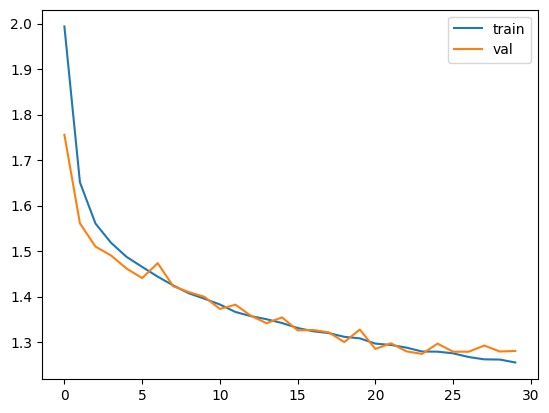

In [33]:
import json

with open(os.path.join(test_dir, 'results.json')) as f:
    results = json.load(f)
results.keys()
plt.figure()
plt.plot(results['train_losses'])
plt.plot(results['val_losses'])
plt.legend(['train', 'val'])

results['accuracy']


/tmp/ipykernel_14991/2277012044.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_feats = torch.load(os.path.join(test_dir, fname))


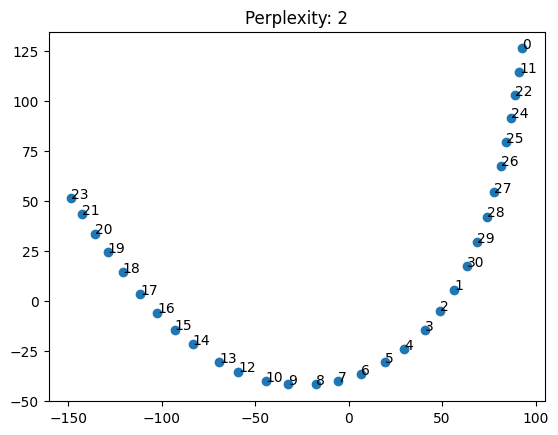

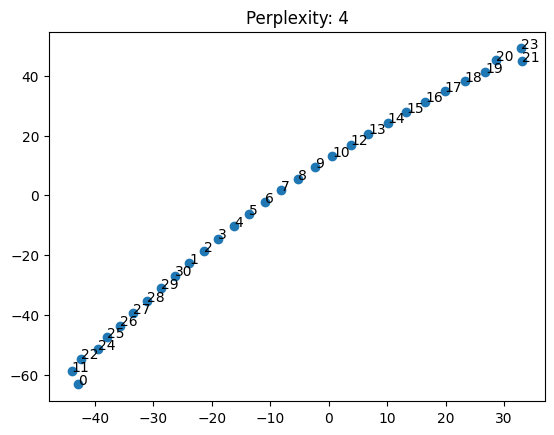

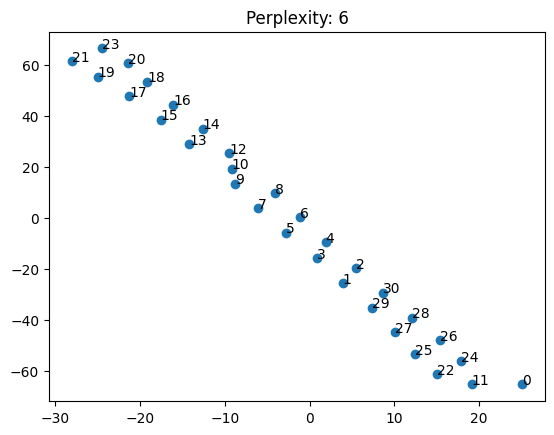

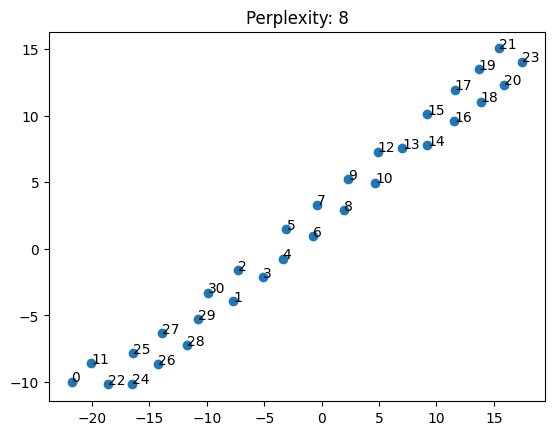

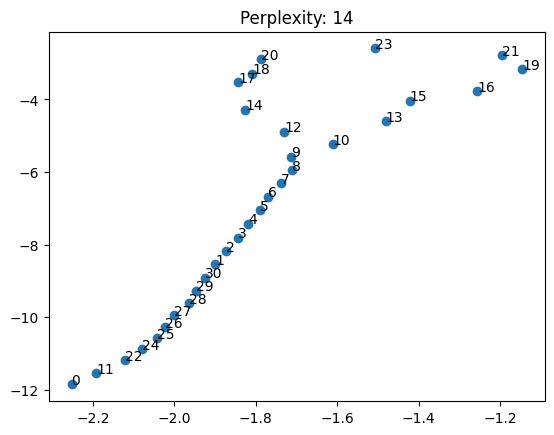

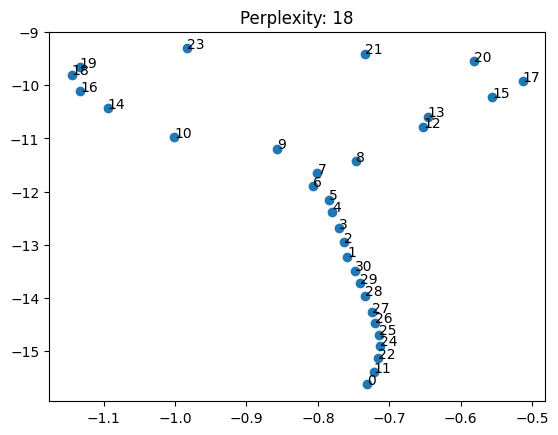

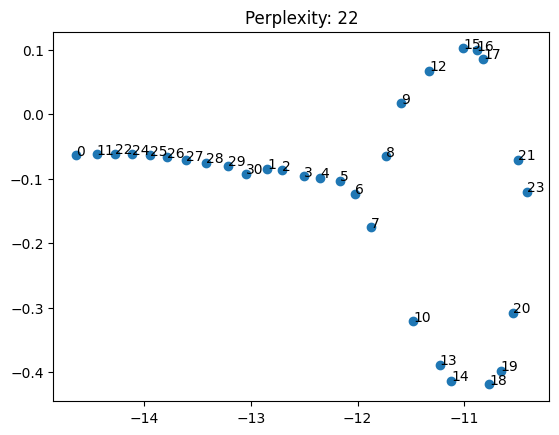

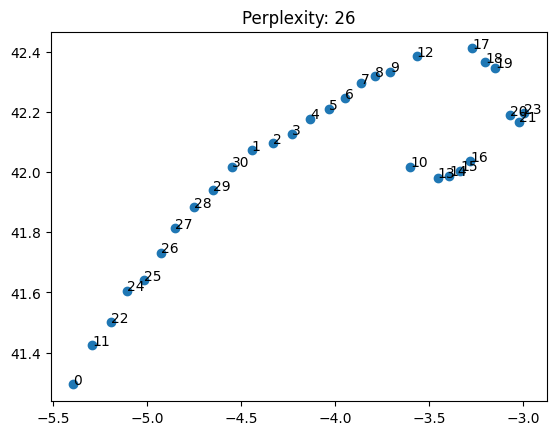

In [47]:
# tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
weights = []
fnames = [f for f in os.listdir(test_dir) if 'epoch' in f]
for fname in fnames:
    final_feats = torch.load(os.path.join(test_dir, fname))
    x, edge_index, edge_attr = final_feats
    weights.append(edge_attr[:, 0].detach().numpy())

weights = np.stack(weights, 0)

for perplexity in [2, 4, 6, 8, 14, 18, 22, 26]:
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsne_weights = tsne.fit_transform(weights)

    # plot with model index as label for each poitn
    plt.figure()
    plt.scatter(tsne_weights[:, 0], tsne_weights[:, 1])
    for i, txt in enumerate(fnames):
        plt.annotate(str(i), (tsne_weights[i, 0], tsne_weights[i, 1]))
    plt.title(f'Perplexity: {perplexity}')
    plt.show()

